In [9]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from keras.models import Sequential, load_model
from keras import losses

from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [46]:
import json
import pandas as pd
import nltk

with open("dialogbot.json") as content:
    data1 = json.load(content)

inputs = []
tags = []
responses = {}
classes = []
documents = []
ignore_words = ['?', '!', '.', ',', '<','>', '-', ':', ';']
words = []

for intent in data1['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(intent['tag'])
        for pattern in intent['patterns']:
            w = nltk.word_tokenize(pattern)
            words.extend(w)
            documents.append((w, intent['tag']))

            if intent['tag'] not in classes:
                classes.append(intent['tag'])

df = pd.DataFrame({"patterns": inputs, "tag": tags})

In [51]:
import string


df['patterns'] = df['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
df['patterns'] = df['patterns'].apply(lambda wrd: ''.join(wrd))

In [52]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lematized words", words)

95 unique lematized words ["'", "'hello", '(', ')', 'ada', 'adalah', 'afternoon', 'antara', 'apa', 'apakah', 'arti', 'atau', 'bagaimana', 'beda', 'bedanya', 'benar', 'berikan', 'bot', 'bro', 'buatkan', 'cara', 'contoh', 'crud', 'dalam', 'dan', 'datatable', 'delete', 'dengan', 'di', 'dong', 'edit', 'form', 'gambar', 'get', 'gimana', 'good', 'hai', 'hallo', 'hapus', 'hello', 'hi', 'html', 'hy', 'ini', 'itu', 'kabarmu', 'kamu', 'kasih', 'kawan', 'kesalahan', 'kode', 'komentar', 'kondisi', 'link', 'makasih', 'malam', 'malem', 'mau', 'membuat', 'menambahkan', 'mendeklarasikan', 'method', 'morning', 'nama', 'nanya', 'night', 'nya', 'pada', 'pagi', 'panggil', 'pengertian', 'penulisan', 'perbedaan', 'php', 'post', 'print', 'sapa', 'saya', 'script', 'sederhana', 'sehat', 'selamat', 'si', 'siang', 'sih', 'sintaksis', 'sore', 'tabel', 'table', 'terima', 'thanks', 'tidak', 'tolong', 'variabel', 'world']


In [53]:
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

26 classes ['berakhir', 'bertanya', 'crud', 'datatable_html', 'delete_php', 'edit_php', 'error', 'form_php', 'gambar_html', 'get_dan_post', 'html', 'komentar', 'link_php', 'menyapa', 'pengertian_html', 'pengertian_php', 'pertanyaan_kabar', 'pertanyaan_nama', 'php', 'sapaan_malam', 'sapaan_pagi', 'sapaan_siang', 'sapaan_sore', 'sapaan_umum', 'tabel_html', 'variabel']


In [54]:
X_train, X_test, y_train, y_test = train_test_split(df['patterns'], df['tag'],
                                                   test_size = 0.2, random_state = 42)

In [55]:
def tfidf(words):
    tfidf_vectorizer = TfidfVectorizer()
    data_feature = tfidf_vectorizer.fit_transform(words)
    return data_feature, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train.tolist())
X_test_tfidf = tfidf_vectorizer.transform(X_test.tolist())

In [56]:
X_train_tfidf.shape

(68, 84)

In [57]:
lr_tfidf = LogisticRegression(random_state=42,solver = 'liblinear')
lr_tfidf.fit(X_train_tfidf, y_train)
y_predicted_lr = lr_tfidf.predict(X_test_tfidf)
def score_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted,average= 'macro')
    recall = recall_score(y_test, y_predicted,average='macro')
    print("accuracy = %0.3f, precision = %0.3f, recall = %0.3f" % (accuracy, precision, recall))
score_metrics(y_test, y_predicted_lr)

accuracy = 0.706, precision = 0.539, recall = 0.588


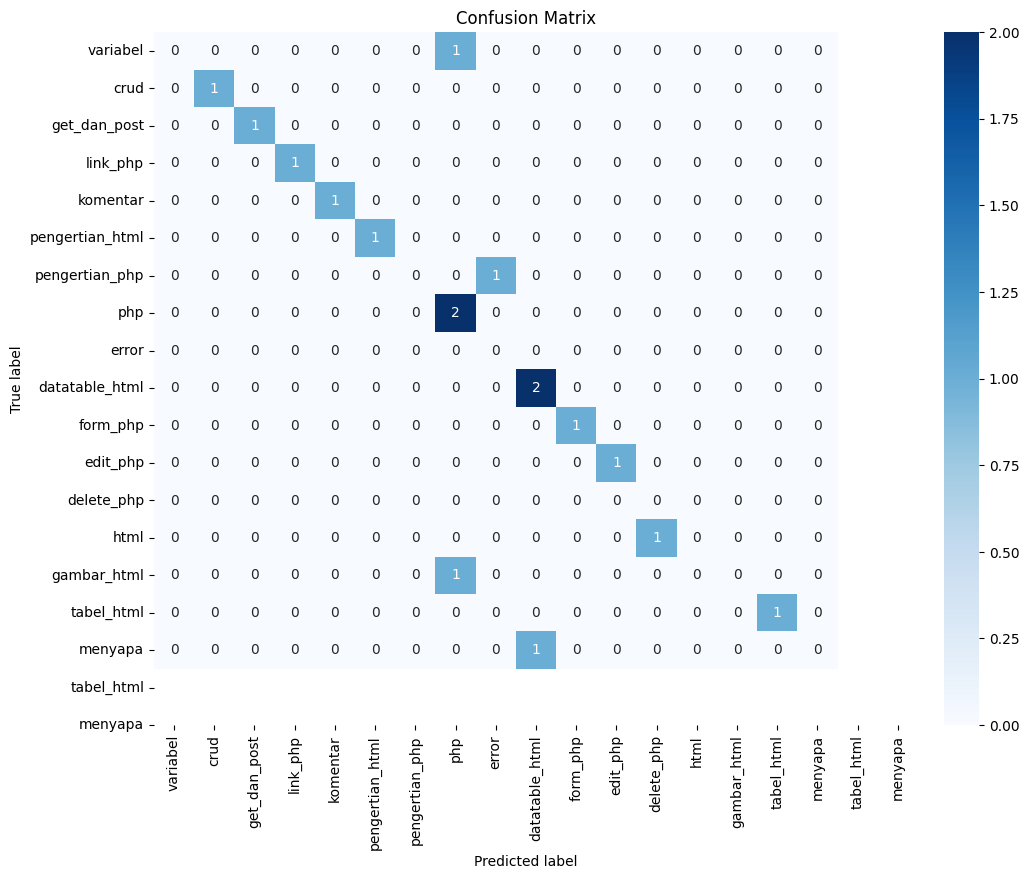

In [66]:
classes = ['variabel', 'crud', 'get_dan_post', 'link_php', 'komentar',
       'pengertian_html', 'pengertian_php', 'php', 'error',
       'datatable_html', 'form_php', 'edit_php', 'delete_php', 'html',
       'gambar_html', 'tabel_html', 'menyapa', 'sapaan_pagi',
       'sapaan_siang', 'sapaan_sore', 'sapaan_malam', 'sapaan_umum',
       'pertanyaan_kabar', 'pertanyaan_nama', 'berakhir', 'bertanya']
def plot_confusion_matrix(y_test, y_predicted, title='Confusion Matrix'):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(y_test, y_predicted_lr)